# 03 BMRA

Run BMRA based on global responses derived from the pathway activity predictions.

In [1]:
import pandas as pd
import numpy as np
import os
import bmra

In [2]:
data_dir_1 = "01_outputs_2020"
data_dir_2 = "02_outputs_2020"
info_dir = "/home/jing/Phd_project/project_GBM/gbm_Scripts/gbm_Scripts_bmra_u251mg"
out_dir = "03_outputs_2020"


os.makedirs(out_dir, exist_ok = True)

## Load data

### Global responses

Assembled from global responses calculated from predicted pathway activities, and DPD global responses.

In [3]:
def assemble_R_global(pathway_rglobal_file, dpd_rglobal_file):
    """
    Assemble full R_global matrix
    """
    R_global_modules_df = pd.read_csv(pathway_rglobal_file, index_col = 0)

    perts = R_global_modules_df.columns.tolist()

    R_global_DPD_df = pd.read_csv(dpd_rglobal_file, index_col=0).T

    # filter by perts list
    R_global_DPD_df = R_global_DPD_df[R_global_DPD_df.index.isin(perts)]

    # sort by perts list
    R_global_DPD_df["sort_col"] = R_global_DPD_df.index.map({val: i for i, val in enumerate(perts)})
    R_global_DPD_df = R_global_DPD_df.sort_values("sort_col")
    R_global_DPD_df = R_global_DPD_df.drop("sort_col", axis = 1)

    # transpose
    R_global_DPD_df = R_global_DPD_df.T

    R_global_df = pd.concat([R_global_modules_df, R_global_DPD_df])

    return R_global_df

In [4]:
R_global_df = assemble_R_global(
    pathway_rglobal_file = os.path.join(data_dir_2, "R_global_annotated.csv"),
    dpd_rglobal_file = os.path.join(data_dir_1, "R_global_DPDonly_annotated.csv"),
)

modules = R_global_df.index.tolist()
exp_ids = R_global_df.columns.tolist()

R_global = R_global_df.values
n_modules = R_global.shape[0]

print(R_global.shape)
display(R_global_df)

(11, 68)


,ASG002_U251MG_24H:A10,ASG002_U251MG_24H:A11,ASG002_U251MG_24H:A12,ASG002_U251MG_24H:B10,ASG002_U251MG_24H:B11,ASG002_U251MG_24H:B12,ASG002_U251MG_24H:B13,ASG002_U251MG_24H:B14,ASG002_U251MG_24H:B15,ASG002_U251MG_24H:C13,...,ASG002_U251MG_24H:M24,ASG002_U251MG_24H:N22,ASG002_U251MG_24H:N23,ASG002_U251MG_24H:N24,ASG002_U251MG_24H:O10,ASG002_U251MG_24H:O11,ASG002_U251MG_24H:O12,ASG002_U251MG_24H:P16,ASG002_U251MG_24H:P17,ASG002_U251MG_24H:P18
CDK2,0.101048,0.092031,-0.011180,0.087682,0.065084,0.091590,0.063799,0.092609,0.045405,0.031242,...,-0.007224,0.029503,0.019165,0.036521,0.073077,-0.001555,0.011468,0.053445,0.097074,-0.138455
CDK4_6,-0.034588,0.036245,0.025466,0.013067,0.022824,-0.015145,0.001511,0.016266,0.024925,0.055222,...,0.070154,-0.021688,0.054562,0.042065,0.013358,0.005930,-0.015422,-1.635673,-1.745908,-1.073442
PI3K,-1.671152,-1.761501,-1.537645,-0.174551,-0.196307,-0.208284,-0.261942,0.007506,-0.172437,-0.143874,...,0.370376,0.102777,-0.024845,0.015664,0.324085,-0.077456,-0.866591,-0.660481,-0.786402,-0.510196
ERK,-1.451296,-1.049523,-0.548311,-0.143077,-0.104596,-0.022933,-0.389746,-0.348772,-0.277734,0.160364,...,0.064283,-0.384334,-0.206127,0.014729,-0.807122,-0.092129,-0.255222,-0.968747,-1.986021,-0.894687
Estrogen,0.035618,0.084747,-0.373749,-0.133320,0.054655,-0.006648,-0.070424,0.032687,0.048627,-0.008743,...,0.018496,-0.259226,-0.042653,-0.044271,-1.657682,-1.387374,-1.384575,-0.316980,0.047511,-0.517700
EGFR,0.250666,0.395559,0.392072,-1.614377,-1.014252,0.369631,-1.613522,0.410030,-1.459887,0.244815,...,-1.669163,-1.957727,-1.465084,-1.304875,0.336743,0.353579,0.509665,-1.899566,0.307060,-1.272544
PDGFR,-0.295805,-0.270717,-0.535213,-0.160155,-0.024668,0.023851,0.347525,0.262103,-0.339739,-0.438132,...,-0.251933,0.014736,-0.430127,-0.399836,-0.709114,0.005942,-0.770148,-1.878563,-1.206355,0.761778
Aurora,0.431648,-0.959191,0.308563,-1.499149,-1.931927,-1.655048,-1.619373,-1.999016,-1.438284,0.247515,...,0.096074,-0.990115,-1.380380,-1.468261,0.535399,-0.231497,0.356256,-1.260173,-1.017660,-1.082805
p53,-0.228942,0.245429,0.094512,-1.595964,-1.572741,-1.505859,-0.776653,-0.279042,0.031126,-1.633360,...,0.394738,0.138466,-0.461514,-1.079353,-0.515582,-0.974651,0.424103,0.151840,0.041004,0.003934
GBM_onc,1.979015,0.221957,0.379708,0.234524,1.089820,0.639857,0.915347,-0.173550,0.077196,1.728283,...,-0.180166,2.531988,0.033434,0.178615,0.311146,-0.030839,-0.291152,1.414242,1.510780,0.047220


In [5]:
print(R_global_df.values.min())
print(R_global_df.values.max())

-19.044110414335425
21.871067677004643


### Perturbation matrix

In [6]:
inhib_conc_df = pd.read_csv(os.path.join(data_dir_1, "inhib_conc_annotated.csv"), index_col = 0)
#LFC_PLCg = pd.read_csv(os.path.join(info_dir,"PLCg_Data_log_2020.csv"),index_col=0)
#inhib_conc = inhib_conc_df.drop(columns=LFC_PLCg.index).values
inhib_conc = inhib_conc_df.values

n_DPDs = R_global.shape[0] - inhib_conc.shape[0]

pert_modules = np.where(inhib_conc != 0, 1, 0)
pert_DPD = np.zeros((n_DPDs, len(exp_ids)))

pert = np.vstack([pert_modules, pert_DPD])

print(pert.shape)
print(pert)

(11, 68)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0.
  0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

### Networks

In [7]:
# empty prior
#G_prior = np.zeros((n_modules, n_modules))
G_prior_df = pd.read_excel('/home/jing/Phd_project/project_GBM/gbm_Scripts/gbm_Scripts_bmra_u251mg/00_outputs_2020_U251MG/ALL_DATA_2020_Jing_u251mg.xlsx', sheet_name = "prior_network", index_col = 0)

G_prior = G_prior_df.values
G_prior_df

,CDK2,CDK4_6,p53,EGFR,Aurora,Estrogen,PDGFR,ERK,PI3K,DPD_GBM_onc,DPD_GBM_survival
CDK2,0,0,0,0,0,0,0,0,0,0,0
CDK4_6,0,0,0,0,0,0,0,0,0,0,0
p53,0,0,0,0,0,0,0,0,0,0,0
EGFR,0,0,0,0,0,0,0,0,0,0,0
Aurora,0,0,0,0,0,0,0,0,0,0,0
Estrogen,0,0,0,0,0,0,0,0,0,0,0
PDGFR,0,0,0,0,0,0,0,0,0,0,0
ERK,0,0,0,0,0,0,0,0,0,0,0
PI3K,0,0,0,0,0,0,0,0,0,0,0
DPD_GBM_onc,0,0,0,0,0,0,0,0,0,0,0


In [8]:
#G_prior_r_df = pd.read_excel(os.path.join(info_dir, "ALL_DATA_2020.xlsx"), sheet_name = "prior_r", index_col = 0)

#G_prior_r = G_prior_r_df.values
#G_prior_r_df

In [9]:
G_not = np.eye(n_modules)
G_not[:, n_modules - n_DPDs :] = 1

G_not

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.]])

## Run BMRA

In [10]:
n_gibbs = 200_000
n_window = 5_000

mode = "all"
n_iterations = 1

In [11]:
G_prior

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [12]:
A_mean, A_sd, r_mean, r_sd = bmra.run_bmra(R_global,
            pert,
            G_prior,
            G_not,
            #r_prior = G_prior_r,
            n_gibbs = n_gibbs,
            n_window = n_window,
            mode = mode,
            n_iterations = n_iterations,
        )

A_mean_df = pd.DataFrame(A_mean, index = modules, columns = modules)
A_sd_df = pd.DataFrame(A_sd, index = modules, columns = modules)
r_mean_df = pd.DataFrame(r_mean, index = modules, columns = modules)
r_sd_df = pd.DataFrame(r_sd, index = modules, columns = modules)

display(A_mean_df)
display(A_sd_df)
display(r_mean_df)
display(r_sd_df)

A_mean_df.to_csv(os.path.join(out_dir, "A_mean.csv"))
A_sd_df.to_csv(os.path.join(out_dir, "A_sd.csv"))
r_mean_df.to_csv(os.path.join(out_dir, "r_mean.csv"))
r_sd_df.to_csv(os.path.join(out_dir, "r_sd.csv"))

,CDK2,CDK4_6,PI3K,ERK,Estrogen,EGFR,PDGFR,Aurora,p53,GBM_onc,GBM_survival
CDK2,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
CDK4_6,0.0,0.0,0.000000,1.0,0.000000,0.000000,0.000000,0.001069,0.0,0.0,0.0
PI3K,0.0,0.0,0.000000,1.0,0.000000,0.000000,0.298538,0.000000,0.0,0.0,0.0
ERK,0.0,1.0,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
Estrogen,0.0,0.0,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.0
EGFR,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0
PDGFR,0.0,1.0,0.523114,0.0,0.157419,0.269773,0.000000,0.730227,0.0,0.0,0.0
Aurora,0.0,0.0,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,1.0,0.0,0.0
p53,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0
GBM_onc,0.0,0.0,0.079013,1.0,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0


,CDK2,CDK4_6,PI3K,ERK,Estrogen,EGFR,PDGFR,Aurora,p53,GBM_onc,GBM_survival
CDK2,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0
CDK4_6,0.0,0.000000e+00,0.000000e+00,1.665335e-15,0.000000,0.000000e+00,0.000000e+00,3.267521e-02,0.000000e+00,0.0,0.0
PI3K,0.0,0.000000e+00,0.000000e+00,2.220446e-15,0.000000,0.000000e+00,4.576166e-01,0.000000e+00,0.000000e+00,0.0,0.0
ERK,0.0,7.771561e-16,7.771561e-16,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0
Estrogen,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,2.886580e-15,0.000000e+00,0.000000e+00,0.0,0.0
EGFR,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,2.664535e-15,0.000000e+00,0.0,0.0
PDGFR,0.0,2.331468e-15,4.994655e-01,0.000000e+00,0.364195,4.438416e-01,0.000000e+00,4.438416e-01,0.000000e+00,0.0,0.0
Aurora,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.554312e-15,0.000000e+00,0.000000e+00,1.554312e-15,0.0,0.0
p53,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,2.442491e-15,0.000000e+00,0.0,0.0
GBM_onc,0.0,0.000000e+00,2.697589e-01,1.110223e-15,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.110223e-15,0.0,0.0


,CDK2,CDK4_6,PI3K,ERK,Estrogen,EGFR,PDGFR,Aurora,p53,GBM_onc,GBM_survival
CDK2,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
CDK4_6,0.0,0.000000,0.000000,0.072799,0.000000,0.000000,0.000000,-0.000007,0.000000,0.0,0.0
PI3K,0.0,0.000000,0.000000,0.206751,0.000000,0.000000,0.031963,0.000000,0.000000,0.0,0.0
ERK,0.0,0.534274,0.525789,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
Estrogen,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.179257,0.000000,0.000000,0.0,0.0
EGFR,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.506160,0.000000,0.0,0.0
PDGFR,0.0,0.397838,0.120935,0.000000,0.049485,0.040387,0.000000,0.105226,0.000000,0.0,0.0
Aurora,0.0,0.000000,0.000000,0.000000,0.000000,0.551472,0.000000,0.000000,0.580670,0.0,0.0
p53,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.236907,0.000000,0.0,0.0
GBM_onc,0.0,0.000000,-0.029948,-0.463992,0.000000,0.000000,0.000000,0.000000,-0.503352,0.0,0.0


,CDK2,CDK4_6,PI3K,ERK,Estrogen,EGFR,PDGFR,Aurora,p53,GBM_onc,GBM_survival
CDK2,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
CDK4_6,0.0,0.000000,0.000000,0.021082,0.00000,0.000000,0.000000,0.000253,0.000000,0.0,0.0
PI3K,0.0,0.000000,0.000000,0.017397,0.00000,0.000000,0.050141,0.000000,0.000000,0.0,0.0
ERK,0.0,0.026631,0.016984,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
Estrogen,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.001298,0.000000,0.000000,0.0,0.0
EGFR,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.001758,0.000000,0.0,0.0
PDGFR,0.0,0.067359,0.121469,0.000000,0.11706,0.067709,0.000000,0.065830,0.000000,0.0,0.0
Aurora,0.0,0.000000,0.000000,0.000000,0.00000,0.012570,0.000000,0.000000,0.020191,0.0,0.0
p53,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.001099,0.000000,0.0,0.0
GBM_onc,0.0,0.000000,0.102829,0.048844,0.00000,0.000000,0.000000,0.000000,0.024650,0.0,0.0


In [13]:
np.fill_diagonal(r_mean_df.values,-1)
rm_minus_inv = pd.DataFrame(np.linalg.pinv(r_mean_df),index=r_mean_df.index,columns=r_mean_df.columns)*(-1)
rm_minus_inv.to_csv(os.path.join(out_dir, 'r_minv.csv'))
display(rm_minus_inv)

,CDK2,CDK4_6,PI3K,ERK,Estrogen,EGFR,PDGFR,Aurora,p53,GBM_onc,GBM_survival
CDK2,1.0,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000,-0.000000e+00,-0.000000,-0.000000,-0.000000e+00,-0.000000e+00
CDK4_6,-0.0,1.046258e+00,4.512940e-02,8.549706e-02,7.202013e-05,0.000225,1.455382e-03,0.000301,0.000175,3.449654e-16,3.833018e-16
PI3K,-0.0,1.453640e-01,1.133167e+00,2.448661e-01,1.808374e-03,0.005817,3.654361e-02,0.007871,0.004571,2.181622e-17,2.206820e-16
ERK,-0.0,6.354193e-01,6.199181e-01,1.174427e+00,9.893015e-04,0.003179,1.999179e-02,0.004300,0.002497,9.678738e-17,4.511634e-16
Estrogen,-0.0,7.846127e-02,2.803224e-02,1.150760e-02,1.008995e+00,0.028936,1.817651e-01,0.039159,0.022738,4.132526e-16,5.860280e-17
EGFR,-0.0,-9.299186e-16,5.183417e-17,-1.160738e-15,-7.500616e-17,1.478540,1.616747e-16,0.867749,0.503876,3.306595e-16,2.076401e-16
PDGFR,-0.0,4.377034e-01,1.563804e-01,6.419621e-02,5.017783e-02,0.161422,1.013993e+00,0.218452,0.126848,-1.749111e-16,2.523793e-16
Aurora,-0.0,-1.301193e-15,-8.303422e-16,-2.042945e-15,2.315441e-16,0.945432,-1.366356e-16,1.714378,0.995487,-6.745627e-17,3.878490e-16
p53,-0.0,1.895250e-16,-2.304648e-16,4.926433e-18,5.397519e-16,0.223980,-1.651494e-16,0.406148,1.235838,-3.231697e-16,1.436535e-17
GBM_onc,-0.0,-2.991828e-01,-3.215733e-01,-5.522577e-01,-5.131854e-04,-0.114390,-1.037045e-02,-0.206666,-0.623357,1.000000e+00,-2.185119e-16


In [14]:
con_mat = pd.DataFrame(columns=['From','To','Strength'])
for con_to in r_mean_df.index:
    for con_from in r_mean_df.columns:
        if ((r_mean_df.loc[con_to,con_from] != 0) & (con_from != con_to)):
            row_df = pd.DataFrame([[con_from,con_to,r_mean_df.loc[con_to,con_from]]],columns=['From','To','Strength'])
            if con_mat.empty:
                con_mat = row_df.copy()
            else:
                con_mat = pd.concat([con_mat,row_df],axis=0,ignore_index=True)
            #con_mat = con_mat.append({'From':con_from,'To':con_to,'Strength':r_mean_df.loc[con_to,con_from]},ignore_index=True)
con_mat.to_csv(os.path.join(out_dir, 'r_net.txt'),sep='\t',index=False)
display(con_mat)

,From,To,Strength
0,ERK,CDK4_6,0.072799
1,Aurora,CDK4_6,-0.000007
2,ERK,PI3K,0.206751
3,PDGFR,PI3K,0.031963
4,CDK4_6,ERK,0.534274
5,PI3K,ERK,0.525789
6,PDGFR,Estrogen,0.179257
7,Aurora,EGFR,0.506160
8,CDK4_6,PDGFR,0.397838
9,PI3K,PDGFR,0.120935


In [15]:
# now the same but with filtered matrices
# threshold value
Athr = 0.5

rm_filt = r_mean_df[np.abs(A_mean_df) > Athr].fillna(0).copy()
np.fill_diagonal(rm_filt.values,-1)
rm_filt.to_csv(os.path.join(out_dir, 'r_mean_filt.csv'))
display(rm_filt)

rm_filt_minus_inv = pd.DataFrame(np.linalg.pinv(rm_filt),index=rm_filt.index,columns=rm_filt.columns)*(-1)
rm_filt_minus_inv.to_csv(os.path.join(out_dir, 'r_minv_filt.csv'))
display(rm_minus_inv)

con_mat = pd.DataFrame(columns=['From','To','Strength'])
for con_to in rm_filt.index:
    for con_from in rm_filt.columns:
        if ((rm_filt.loc[con_to,con_from] != 0) & (con_from != con_to)):
            row_df = pd.DataFrame([[con_from,con_to,rm_filt.loc[con_to,con_from]]],columns=['From','To','Strength'])
            if con_mat.empty:
                con_mat = row_df.copy()
            else:
                con_mat = pd.concat([con_mat,row_df],axis=0,ignore_index=True)
            #con_mat = con_mat.append({'From':con_from,'To':con_to,'Strength':r_mean_df.loc[con_to,con_from]},ignore_index=True)
con_mat.to_csv(os.path.join(out_dir, 'r_net_filt.txt'),sep='\t',index=False)
#display(con_mat)


,CDK2,CDK4_6,PI3K,ERK,Estrogen,EGFR,PDGFR,Aurora,p53,GBM_onc,GBM_survival
CDK2,-1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
CDK4_6,0.0,-1.000000,0.000000,0.072799,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
PI3K,0.0,0.000000,-1.000000,0.206751,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
ERK,0.0,0.534274,0.525789,-1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
Estrogen,0.0,0.000000,0.000000,0.000000,-1.0,0.000000,0.179257,0.000000,0.000000,0.0,0.0
EGFR,0.0,0.000000,0.000000,0.000000,0.0,-1.000000,0.000000,0.506160,0.000000,0.0,0.0
PDGFR,0.0,0.397838,0.120935,0.000000,0.0,0.000000,-1.000000,0.105226,0.000000,0.0,0.0
Aurora,0.0,0.000000,0.000000,0.000000,0.0,0.551472,0.000000,-1.000000,0.580670,0.0,0.0
p53,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.236907,-1.000000,0.0,0.0
GBM_onc,0.0,0.000000,0.000000,-0.463992,0.0,0.000000,0.000000,0.000000,-0.503352,-1.0,0.0


,CDK2,CDK4_6,PI3K,ERK,Estrogen,EGFR,PDGFR,Aurora,p53,GBM_onc,GBM_survival
CDK2,1.0,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000,-0.000000e+00,-0.000000,-0.000000,-0.000000e+00,-0.000000e+00
CDK4_6,-0.0,1.046258e+00,4.512940e-02,8.549706e-02,7.202013e-05,0.000225,1.455382e-03,0.000301,0.000175,3.449654e-16,3.833018e-16
PI3K,-0.0,1.453640e-01,1.133167e+00,2.448661e-01,1.808374e-03,0.005817,3.654361e-02,0.007871,0.004571,2.181622e-17,2.206820e-16
ERK,-0.0,6.354193e-01,6.199181e-01,1.174427e+00,9.893015e-04,0.003179,1.999179e-02,0.004300,0.002497,9.678738e-17,4.511634e-16
Estrogen,-0.0,7.846127e-02,2.803224e-02,1.150760e-02,1.008995e+00,0.028936,1.817651e-01,0.039159,0.022738,4.132526e-16,5.860280e-17
EGFR,-0.0,-9.299186e-16,5.183417e-17,-1.160738e-15,-7.500616e-17,1.478540,1.616747e-16,0.867749,0.503876,3.306595e-16,2.076401e-16
PDGFR,-0.0,4.377034e-01,1.563804e-01,6.419621e-02,5.017783e-02,0.161422,1.013993e+00,0.218452,0.126848,-1.749111e-16,2.523793e-16
Aurora,-0.0,-1.301193e-15,-8.303422e-16,-2.042945e-15,2.315441e-16,0.945432,-1.366356e-16,1.714378,0.995487,-6.745627e-17,3.878490e-16
p53,-0.0,1.895250e-16,-2.304648e-16,4.926433e-18,5.397519e-16,0.223980,-1.651494e-16,0.406148,1.235838,-3.231697e-16,1.436535e-17
GBM_onc,-0.0,-2.991828e-01,-3.215733e-01,-5.522577e-01,-5.131854e-04,-0.114390,-1.037045e-02,-0.206666,-0.623357,1.000000e+00,-2.185119e-16


In [16]:
# number of zero elements in the matrix
display(len(rm_filt.index)*len(rm_filt.columns) - rm_filt.astype(bool).sum().sum())

94

In [17]:
# number of non-zero elements in the matrix
display(rm_filt.astype(bool).sum().sum() - len(modules))

16

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
rm_minus_inv=pd.read_csv(os.path.join(out_dir, 'r_minv.csv'),index_col=0)
display(rm_minus_inv)

,CDK2,CDK4_6,PI3K,ERK,Estrogen,EGFR,PDGFR,Aurora,p53,GBM_onc,GBM_survival
CDK2,1.0,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000,-0.000000e+00,-0.000000,-0.000000,-0.000000e+00,-0.000000e+00
CDK4_6,-0.0,1.046258e+00,4.512940e-02,8.549706e-02,7.202013e-05,0.000225,1.455382e-03,0.000301,0.000175,3.449654e-16,3.833018e-16
PI3K,-0.0,1.453640e-01,1.133167e+00,2.448661e-01,1.808374e-03,0.005817,3.654361e-02,0.007871,0.004571,2.181622e-17,2.206820e-16
ERK,-0.0,6.354193e-01,6.199181e-01,1.174427e+00,9.893015e-04,0.003179,1.999179e-02,0.004300,0.002497,9.678738e-17,4.511634e-16
Estrogen,-0.0,7.846127e-02,2.803224e-02,1.150760e-02,1.008995e+00,0.028936,1.817651e-01,0.039159,0.022738,4.132526e-16,5.860280e-17
EGFR,-0.0,-9.299186e-16,5.183417e-17,-1.160738e-15,-7.500616e-17,1.478540,1.616747e-16,0.867749,0.503876,3.306595e-16,2.076401e-16
PDGFR,-0.0,4.377034e-01,1.563804e-01,6.419621e-02,5.017783e-02,0.161422,1.013993e+00,0.218452,0.126848,-1.749111e-16,2.523793e-16
Aurora,-0.0,-1.301193e-15,-8.303422e-16,-2.042945e-15,2.315441e-16,0.945432,-1.366356e-16,1.714378,0.995487,-6.745627e-17,3.878490e-16
p53,-0.0,1.895250e-16,-2.304648e-16,4.926433e-18,5.397519e-16,0.223980,-1.651494e-16,0.406148,1.235838,-3.231697e-16,1.436535e-17
GBM_onc,-0.0,-2.991828e-01,-3.215733e-01,-5.522577e-01,-5.131854e-04,-0.114390,-1.037045e-02,-0.206666,-0.623357,1.000000e+00,-2.185119e-16


In [20]:
rm_minus_inv.columns

Index(['CDK2', 'CDK4_6', 'PI3K', 'ERK', 'Estrogen', 'EGFR', 'PDGFR', 'Aurora',
       'p53', 'GBM_onc', 'GBM_survival'],
      dtype='object')

In [23]:
df_subset=rm_minus_inv[[ 'CDK2', 'CDK4_6', 'PI3K', 'ERK', 'Estrogen', 'EGFR', 
       'PDGFR', 'Aurora', 'p53']]
df_subset = df_subset.loc[['GBM_onc', 'GBM_survival']]

In [24]:
t_df_subset=df_subset.T

In [25]:
df_subset.reset_index(inplace=True)

In [26]:
df_subset

,index,CDK2,CDK4_6,PI3K,ERK,Estrogen,EGFR,PDGFR,Aurora,p53
0,GBM_onc,-0.0,-0.299183,-0.321573,-0.552258,-0.000513,-0.114390,-0.010370,-0.206666,-0.623357
1,GBM_survival,-0.0,-3.104932,-3.029187,-5.738754,-0.004834,4.702451,-0.097689,2.747956,1.595655


Text(0.5, 1.0, 'Predicted global signaling pathway responses of U251MG cell line under conditions ')

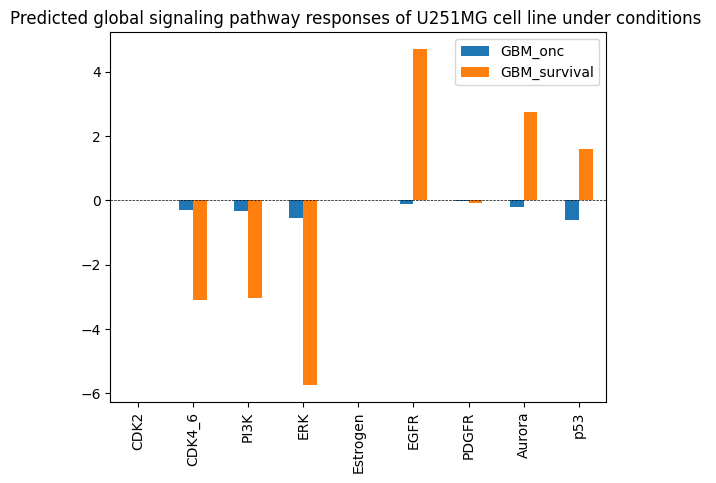

In [27]:
t_df_subset.plot.bar()
plt.axhline(y=0, linestyle='--', color='black',linewidth=0.5)
plt.title("Predicted global signaling pathway responses of U251MG cell line under conditions ")

In [28]:
rm_filt

,CDK2,CDK4_6,PI3K,ERK,Estrogen,EGFR,PDGFR,Aurora,p53,GBM_onc,GBM_survival
CDK2,-1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
CDK4_6,0.0,-1.000000,0.000000,0.072799,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
PI3K,0.0,0.000000,-1.000000,0.206751,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
ERK,0.0,0.534274,0.525789,-1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
Estrogen,0.0,0.000000,0.000000,0.000000,-1.0,0.000000,0.179257,0.000000,0.000000,0.0,0.0
EGFR,0.0,0.000000,0.000000,0.000000,0.0,-1.000000,0.000000,0.506160,0.000000,0.0,0.0
PDGFR,0.0,0.397838,0.120935,0.000000,0.0,0.000000,-1.000000,0.105226,0.000000,0.0,0.0
Aurora,0.0,0.000000,0.000000,0.000000,0.0,0.551472,0.000000,-1.000000,0.580670,0.0,0.0
p53,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.236907,-1.000000,0.0,0.0
GBM_onc,0.0,0.000000,0.000000,-0.463992,0.0,0.000000,0.000000,0.000000,-0.503352,-1.0,0.0


In [29]:
display(rm_filt)
rm_subset=rm_filt[['CDK2', 'CDK4_6', 'PI3K', 'ERK', 'PDGFR', 'Aurora','Estrogen', 'EGFR','p53']]

,CDK2,CDK4_6,PI3K,ERK,Estrogen,EGFR,PDGFR,Aurora,p53,GBM_onc,GBM_survival
CDK2,-1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
CDK4_6,0.0,-1.000000,0.000000,0.072799,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
PI3K,0.0,0.000000,-1.000000,0.206751,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
ERK,0.0,0.534274,0.525789,-1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
Estrogen,0.0,0.000000,0.000000,0.000000,-1.0,0.000000,0.179257,0.000000,0.000000,0.0,0.0
EGFR,0.0,0.000000,0.000000,0.000000,0.0,-1.000000,0.000000,0.506160,0.000000,0.0,0.0
PDGFR,0.0,0.397838,0.120935,0.000000,0.0,0.000000,-1.000000,0.105226,0.000000,0.0,0.0
Aurora,0.0,0.000000,0.000000,0.000000,0.0,0.551472,0.000000,-1.000000,0.580670,0.0,0.0
p53,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.236907,-1.000000,0.0,0.0
GBM_onc,0.0,0.000000,0.000000,-0.463992,0.0,0.000000,0.000000,0.000000,-0.503352,-1.0,0.0


In [30]:
rm_subset

,CDK2,CDK4_6,PI3K,ERK,PDGFR,Aurora,Estrogen,EGFR,p53
CDK2,-1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
CDK4_6,0.0,-1.000000,0.000000,0.072799,0.000000,0.000000,0.0,0.000000,0.000000
PI3K,0.0,0.000000,-1.000000,0.206751,0.000000,0.000000,0.0,0.000000,0.000000
ERK,0.0,0.534274,0.525789,-1.000000,0.000000,0.000000,0.0,0.000000,0.000000
Estrogen,0.0,0.000000,0.000000,0.000000,0.179257,0.000000,-1.0,0.000000,0.000000
EGFR,0.0,0.000000,0.000000,0.000000,0.000000,0.506160,0.0,-1.000000,0.000000
PDGFR,0.0,0.397838,0.120935,0.000000,-1.000000,0.105226,0.0,0.000000,0.000000
Aurora,0.0,0.000000,0.000000,0.000000,0.000000,-1.000000,0.0,0.551472,0.580670
p53,0.0,0.000000,0.000000,0.000000,0.000000,0.236907,0.0,0.000000,-1.000000
GBM_onc,0.0,0.000000,0.000000,-0.463992,0.000000,0.000000,0.0,0.000000,-0.503352


In [31]:
rm_subset=rm_subset.loc[['GBM_onc','GBM_survival']]
rm_subset=rm_subset.T
display(rm_subset)

,GBM_onc,GBM_survival
CDK2,0.000000,0.000000
CDK4_6,0.000000,0.000000
PI3K,0.000000,0.000000
ERK,-0.463992,-4.886430
PDGFR,0.000000,0.000000
Aurora,0.000000,0.000000
Estrogen,0.000000,0.000000
EGFR,0.000000,3.190974
p53,-0.503352,0.000000


Text(0.5, 1.0, 'Predicted local signaling pathway responses of U251MG cell line under conditions ')

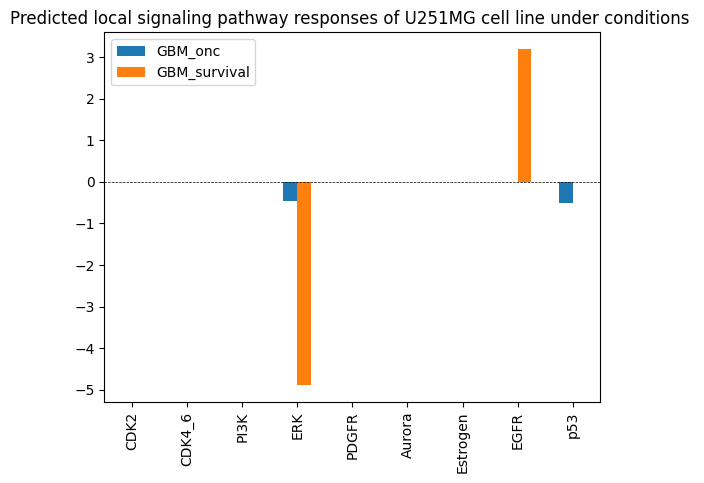

In [32]:
rm_subset.plot.bar()
plt.axhline(y=0, linestyle='--', color='black',linewidth=0.5)
plt.title("Predicted local signaling pathway responses of U251MG cell line under conditions ")